---
##### Import Necessary Libraries and Setup Device
---

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# 1. Device Setup: This makes the code work for the whole team
if torch.backends.mps.is_available():
    device = torch.device("mps") # Mac M2
    print("Device: Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda") # Windows (if NVIDIA GPU exists)
    print("Device: NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")  # Intel Mac / standard Windows
    print("Device: CPU")

# 2. Path Standardization
# Using os.path.join ensures paths work on both Windows (\) and Mac (/)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed_dataset")

print(f"Project Directory: {BASE_DIR}")

Device: Apple Silicon GPU (MPS)
Project Directory: /Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/Project-2530/Project Code


---
##### Data Architecture & Cleaning
---

In [8]:
# 1. Path Configuration
# Use relative paths for better portability among groupmates
RAW_DATA_PATH = "/Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/Project-2530/Project Code/Dataset"
PROCESSED_PATH = os.path.join("dataset_final")

def organize_and_clean(src, dst):
    categories = ['Fresh', 'Rotten']
    for cat in categories:
        os.makedirs(os.path.join(dst, cat), exist_ok=True)

    MAX_IMAGES_PER_FRUIT = 3000 
    fruit_tracker = {} 

    print(f"Starting balanced cleaning and merging from: {src}")
    stats = {"Fresh": 0, "Rotten": 0, "Skipped": 0, "Capped": 0}

    for root, dirs, files in os.walk(src):
        # Determine the label by looking at the full path string
        path_lower = root.lower()
        
        # Skip the root directory and only look for folders with 'fresh' or 'rotten'
        if 'fresh' in path_lower:
            current_label = 'Fresh'
        elif 'rotten' in path_lower:
            current_label = 'Rotten'
        else:
            continue # If the folder doesn't say fresh or rotten, ignore it

        # Use the folder name to track the specific fruit (e.g., 'apple')
        fruit_name = os.path.basename(root).lower()
        if fruit_name not in fruit_tracker:
            fruit_tracker[fruit_name] = 0

        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(root, file)
                
                try:
                    if os.path.getsize(src_path) <= 0:
                        stats["Skipped"] += 1
                        continue
                    
                    if fruit_tracker[fruit_name] >= MAX_IMAGES_PER_FRUIT:
                        stats["Capped"] += 1
                        continue
                    
                    unique_name = f"{fruit_name}_{file}"
                    dst_path = os.path.join(dst, current_label, unique_name)
                    
                    shutil.copy2(src_path, dst_path)
                    
                    fruit_tracker[fruit_name] += 1
                    stats[current_label] += 1
                    
                except (OSError, IOError):
                    stats["Skipped"] += 1
                    continue

    print("\n--- Corrected Data Summary ---")
    print(f"Fresh Images: {stats['Fresh']}")
    print(f"Rotten Images: {stats['Rotten']}")
    print(f"Files Capped: {stats['Capped']}")
    print(f"Files Skipped: {stats['Skipped']}")

organize_and_clean(RAW_DATA_PATH, PROCESSED_PATH)

Starting balanced cleaning and merging from: /Users/galohsafiya/Documents/Year 3 Sem 2/Visual Image Processing/Project-2530/Project Code/Dataset

--- Corrected Data Summary ---
Fresh Images: 21025
Rotten Images: 20194
Files Capped: 30084
Files Skipped: 0


---
##### Data Augmentation
---

In [13]:
import numpy as np
from torch.utils.data import WeightedRandomSampler, Subset

# 1. Transform setup (remains the same)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Load the full dataset
full_dataset = datasets.ImageFolder(PROCESSED_PATH, transform=transform)

# 3. Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])

# 4. Technical Component: Fixed Weighted Sampling
# We calculate weights ONLY for the training subset to avoid IndexError
train_labels = [full_dataset.targets[i] for i in train_indices]
class_sample_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in train_labels])
sampler = WeightedRandomSampler(torch.from_numpy(samples_weight).type(torch.DoubleTensor), len(samples_weight))

# 5. Create the Subset objects
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)

# 6. Create Loaders
# num_workers=0 is best for 8GB RAM to prevent memory spikes
train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)

print(f"Fixed Sampler for Training: {len(train_data)} images")
print(f"Validation Set: {len(val_data)} images")

Fixed Sampler for Training: 32975 images
Validation Set: 8244 images


---
##### Model Training (MobileNetV2)
---

In [ ]:
# 1. Load Pre-trained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# 2. Freeze the backbone (Feature Extractor)
# Technical Component: Transfer Learning
for param in model.parameters():
    param.requires_grad = False

# 3. Modify Classifier for Binary Freshness Detection
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Dropout(0.3), 
    nn.Linear(128, 2) 
)

# 4. Move model to M2 GPU
model = model.to(device)

# 5. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# 6. Training Loop
num_epochs = 5 
train_losses, train_accs = [], []

print(f"Training MobileNetV2 on {device}...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # tqdm progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Calculate metrics
    epoch_loss = running_loss / len(train_data)
    
    # Use .float() instead of .double() to satisfy the MPS framework
    epoch_acc = running_corrects.float() / len(train_data)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item()) # .item() handles the move to CPU automatically
    
    print(f"Epoch {epoch+1} Complete: Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# 7. Save weights for the final application
torch.save(model.state_dict(), 'mobilenet_freshness.pth')
print("Model weights saved to 'mobilenet_freshness.pth'")

Training MobileNetV2 on mps...


Epoch 1/5: 100%|██████████| 1031/1031 [05:36<00:00,  3.07it/s]


✅ Epoch 1 Complete: Loss: 0.3080 | Accuracy: 0.8685


Epoch 2/5: 100%|██████████| 1031/1031 [05:40<00:00,  3.03it/s]


✅ Epoch 2 Complete: Loss: 0.2300 | Accuracy: 0.9086


Epoch 3/5: 100%|██████████| 1031/1031 [05:31<00:00,  3.11it/s]


✅ Epoch 3 Complete: Loss: 0.2017 | Accuracy: 0.9221


Epoch 4/5: 100%|██████████| 1031/1031 [05:29<00:00,  3.13it/s]


✅ Epoch 4 Complete: Loss: 0.1796 | Accuracy: 0.9323


Epoch 5/5: 100%|██████████| 1031/1031 [05:28<00:00,  3.14it/s]


✅ Epoch 5 Complete: Loss: 0.1620 | Accuracy: 0.9368
Model weights saved to 'mobilenet_freshness.pth'


In [18]:
# 1. Load Pre-trained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# 2. Fine-Tuning Strategy (Technical Depth)
# Initially freeze all, then unfreeze the last block of the backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional block to adapt to food textures
# This addresses "Data Optimization" for better feature extraction 
for param in model.features[14:].parameters():
    param.requires_grad = True

# 3. Modify Classifier with Dropout
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Dropout(0.4), # Increased dropout for better regularization
    nn.Linear(128, 2) 
)

model = model.to(device)

# 4. Optimizer with Weight Decay 
criterion = nn.CrossEntropyLoss()
# Note: optimizer now tracks both classifier and the unfrozen backbone layers
optimizer = optim.Adam([
    {'params': model.classifier.parameters(), 'lr': 0.001},
    {'params': model.features[14:].parameters(), 'lr': 0.0001} # Lower LR for fine-tuning (Slide 79)
], weight_decay=1e-4)

# 5. Learning Rate Scheduler 
# Reduces LR if validation accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)

# 6. Training Loop with Accuracy
num_epochs = 7
train_losses, train_accs = [], []

print(f"Starting Optimized Training on {device}...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_data)
    epoch_acc = running_corrects.float() / len(train_data)
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())
    
    # Update Scheduler based on accuracy
    scheduler.step(epoch_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | LR: {current_lr}")

# 7. Save weights
torch.save(model.state_dict(), 'mobilenet_freshness_optimized.pth')
print("Optimized model weights saved.")

Starting Optimized Training on mps...


Epoch 1/7: 100%|██████████| 1031/1031 [06:32<00:00,  2.63it/s]


Epoch 1: Loss: 0.1880 | Acc: 0.9276 | LR: 0.001


Epoch 2/7: 100%|██████████| 1031/1031 [06:33<00:00,  2.62it/s]


Epoch 2: Loss: 0.1064 | Acc: 0.9612 | LR: 0.001


Epoch 3/7: 100%|██████████| 1031/1031 [06:33<00:00,  2.62it/s]


Epoch 3: Loss: 0.0826 | Acc: 0.9704 | LR: 0.001


Epoch 4/7: 100%|██████████| 1031/1031 [06:24<00:00,  2.68it/s]


Epoch 4: Loss: 0.0685 | Acc: 0.9747 | LR: 0.001


Epoch 5/7: 100%|██████████| 1031/1031 [06:39<00:00,  2.58it/s]


Epoch 5: Loss: 0.0612 | Acc: 0.9776 | LR: 0.001


Epoch 6/7: 100%|██████████| 1031/1031 [06:29<00:00,  2.65it/s]


Epoch 6: Loss: 0.0555 | Acc: 0.9793 | LR: 0.001


Epoch 7/7: 100%|██████████| 1031/1031 [06:30<00:00,  2.64it/s]


Epoch 7: Loss: 0.0513 | Acc: 0.9807 | LR: 0.001
Optimized model weights saved.


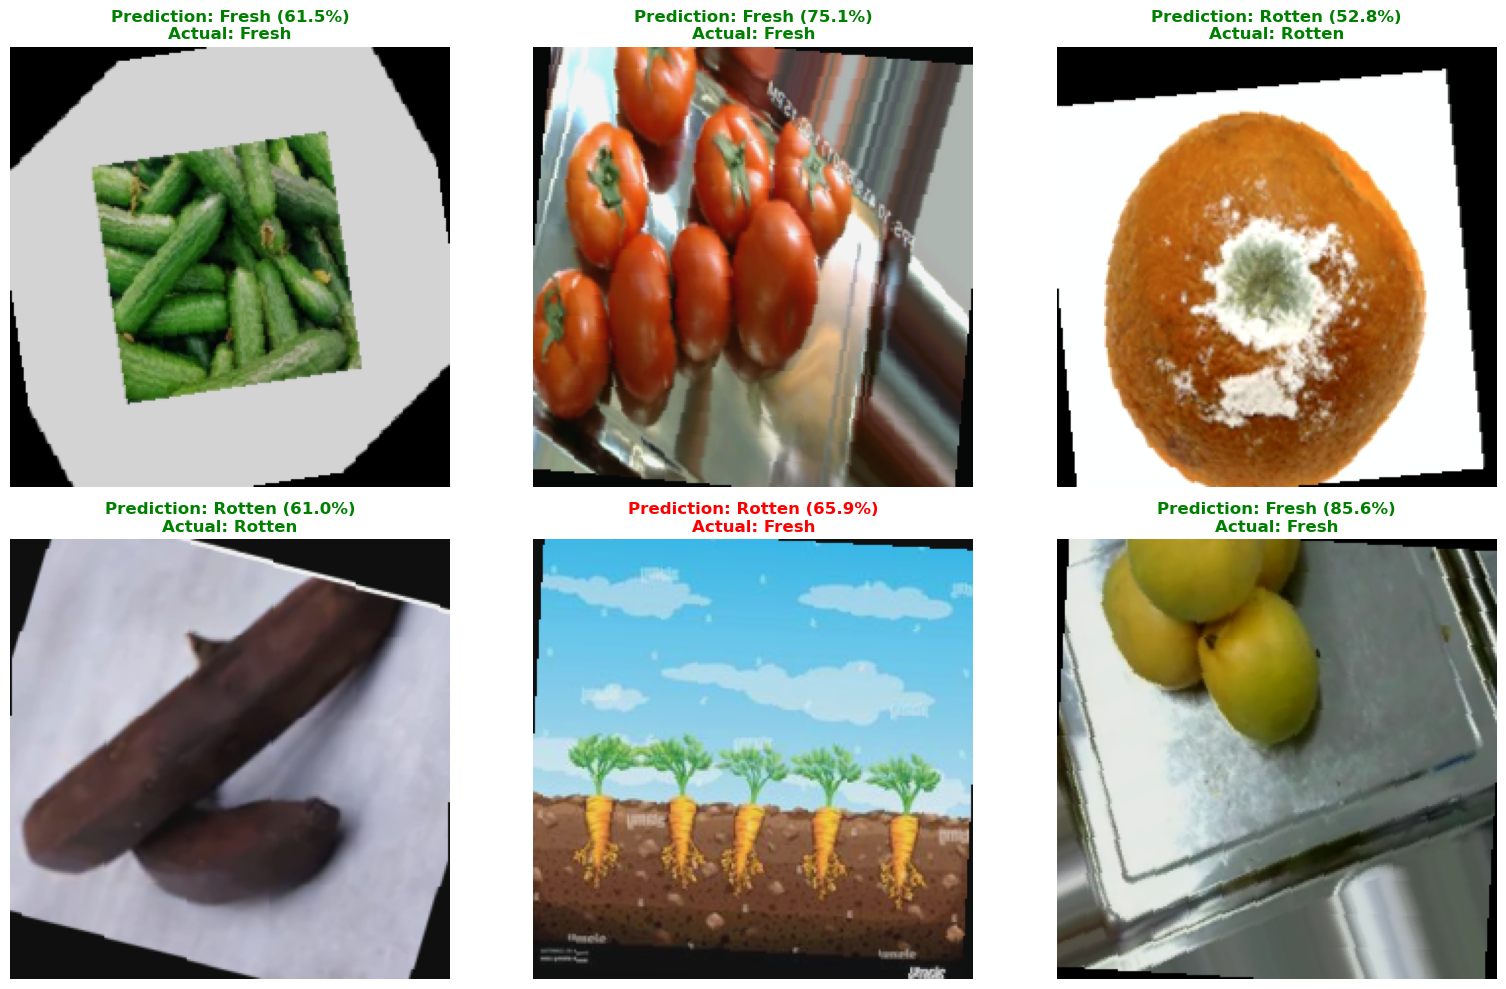

In [20]:
import torch.nn.functional as F

def visualize_results(model, loader, num_images=6):
    model.eval()
    
    # Get a batch of validation images
    images, labels = next(iter(loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)
    
    # Perform prediction
    with torch.no_grad():
        outputs = model(images)
        # Convert raw outputs (logits) to probabilities
        probabilities = F.softmax(outputs, dim=1)
        confidences, preds = torch.max(probabilities, 1)
        
    plt.figure(figsize=(16, 10))
    
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        
        # --- Technical Step: Un-normalize for Human Viewing ---
        # Convert back from Tensor to Numpy and reverse the ImageNet normalization
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # Ensure pixels are in [0,1] range
        
        plt.imshow(img)
        
        # Color coding: Green for correct, Red for wrong
        is_correct = preds[i] == labels[i]
        title_color = "green" if is_correct else "red"
        
        pred_label = full_dataset.classes[preds[i]]
        actual_label = full_dataset.classes[labels[i]]
        conf_percent = confidences[i].item() * 100
        
        plt.title(f"Prediction: {pred_label} ({conf_percent:.1f}%)\nActual: {actual_label}", 
                  color=title_color, fontsize=12, fontweight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Execute visualization
visualize_results(model, val_loader)